In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
import warnings


2023-11-16 14:39:41.861574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h1>Hyperparameters<h1>


In [ ]:
K = 5 # validation folds
MIN_LAG = 120
MAX_LAG = 144
SEED = 42
VAL_SPLIT = 0.2

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<h1>Creating DataFrames<h1>

In [ ]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [ ]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]
DF_STRINGS = ["Oslo","Stavanger","Trondheim","Tromsø","Bergen"]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs

In [ ]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_interaction_column(df,col1, col2):
    df[f"{col1}_X_{col2}"] = df[col1]*df[col2]
    return df.dropna() 

In [ ]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    DFS[i].index = pd.to_datetime(DFS[i].index)
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=24,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_holiday")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_holiday")
    DFS[i] = DFS[i].dropna(axis=0)


/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_58524/2288344897.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_58524/2288344897.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/js/9hpr3tt17xd6ttv9xy3zrhw80000gn/T/ipykernel_58524/2288344897.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

<h1>Training<h1>

In [ ]:
# k-Fold for validation
k = K
np.random.seed(SEED)


def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

def custom_train_val_split(data, val_split):
    thresh = np.floor(len(data) * (1 - val_split)).astype(int)
    return data.iloc[:thresh], data.iloc[thresh:]

In [ ]:
def cross_validate(data,alpha1,alpha2,mu,sig):
    mape_values = []
    L = len(data)
    offsets = range(1,L,np.floor(L/k))
    for offset in offsets:
        X = data.iloc[offset:offset + np.floor(L/k)]
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)
        model1 = Lasso(alpha = alpha1,max_iter=200,tol=10**(-3))
        model1.fit(X_train, y1_train)
        y1_pred = model1.predict(X_val)

        model2 = Lasso(alpha = alpha2,max_iter=200,tol=10**(-3))
        model2.fit(X_train, y2_train)
        y2_pred = model2.predict(X_val)

        mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu))) * 100
        mape_values.append(mape)
    average_mape = np.mean(mape_values)
        # Averaging MAPE across all folds
    return average_mape

Oslo
Alpha1, alpha2 --> MAPE
2.384185791015625e-07 0.0005 --> 1.6936974375694873
Best Hyperparameters: (2.384185791015625e-07, 0.0005)
Best CV MAPE: 1.6936974375694873%


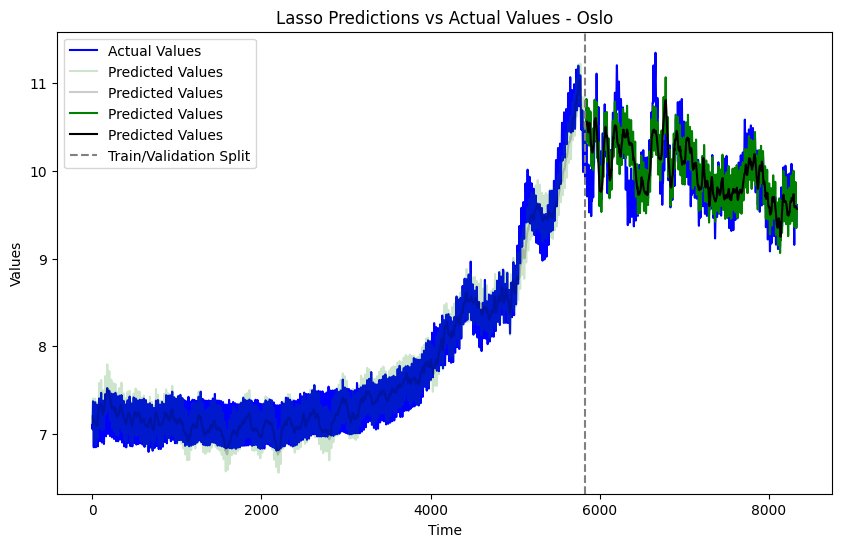

Out of sample MAPE: 2.0504867101745274
Mean oveprediction: 2.3811319421808483
Mean underprediction: 1.6755107339965658
MAPE with trend prediction only: 2.4302099088013307
Intercept: 
6.937468165674628
Coefficients: 
is_weekend: 0.03026293257958481
hour: 0.0015853100130006734
month: 0.11277115753322106
temperature_seasonal: 0.1329321616236569
spot_price_seasonal: 0.060082630155249755
temperature_trend_L119: 0.0007785419081514118
temperature_trend_L120: 0.02690636104462081
temperature_trend_L121: 0.022075555843412843
temperature_trend_L122: 0.017197643224722475
temperature_trend_L123: 0.012605068154633846
temperature_trend_L124: 0.011487869529652387
temperature_trend_L125: 0.006509605702295435
temperature_trend_L126: 0.002197921782451602
temperature_trend_L127: 0.00021756849598329942
temperature_trend_L141: 0.0037890544552681977
temperature_trend_L142: 0.04308948739424748
temperature_trend_L143: 0.05478221896359237
temperature_trend_L144: 0.06669691928885638
temperature_seasonal_L24: 0.0

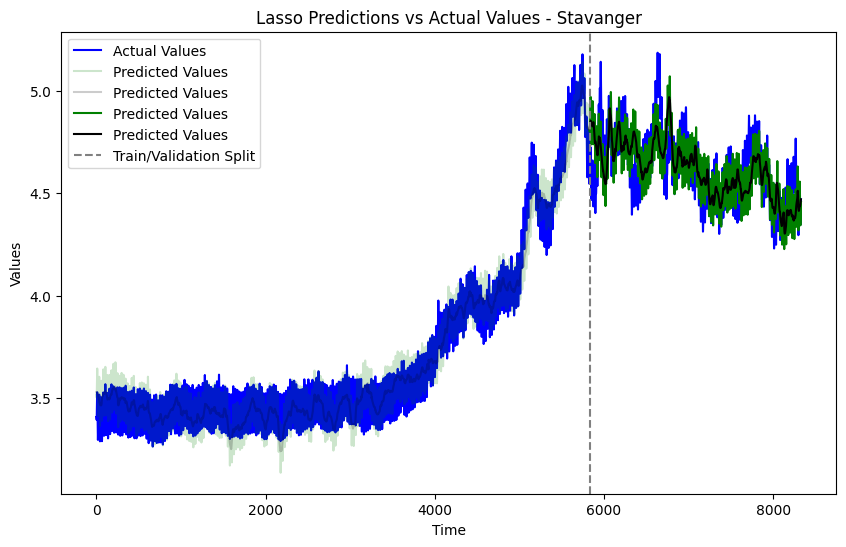

Out of sample MAPE: 2.031543480145614
Mean oveprediction: 2.100717314864203
Mean underprediction: 1.9731413643389242
MAPE with trend prediction only: 2.3757860819413703
Intercept: 
3.3684809213966846
Coefficients: 
is_weekend: 0.009152044957755562
hour: 3.186906351231611e-05
month: 0.0833676914246257
temperature_seasonal: 0.05873223950396643
spot_price_seasonal: 0.20568028191486645
temperature_trend_L120: 0.00619881931147539
temperature_trend_L121: 0.004383670074814907
temperature_trend_L122: 0.0026867127247404616
temperature_trend_L123: 0.001283873607325395
temperature_trend_L124: 0.0002797963935534595
temperature_trend_L142: 0.017304135174884456
temperature_trend_L143: 0.021238046565250544
temperature_trend_L144: 0.024881215207257234
temperature_seasonal_L24: 0.007053642952964021
temperature_seasonal_L25: 0.03443145173688195
temperature_seasonal_L26: 0.03318036719674929
temperature_seasonal_L27: 0.037249222636399355
temperature_seasonal_L28: 0.05925304067010527
temperature_seasonal_L

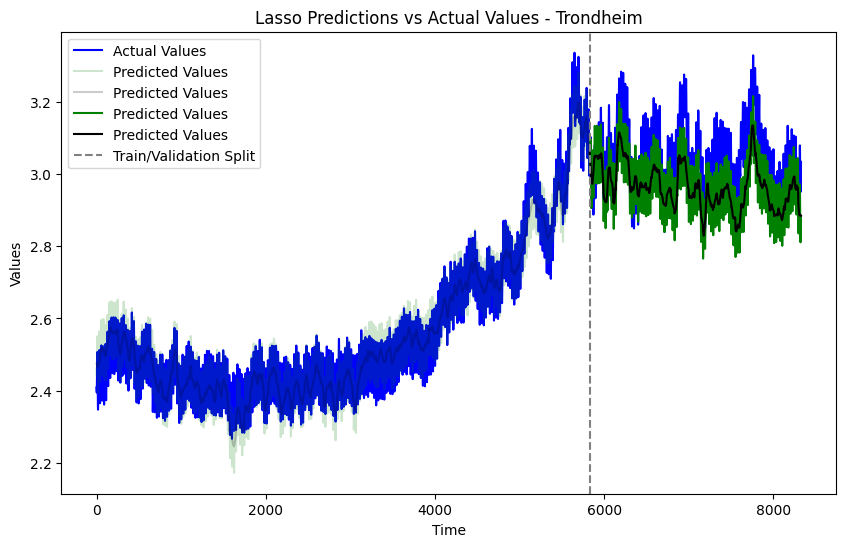

Out of sample MAPE: 2.7114833031053944
Mean oveprediction: 0.9563871573538097
Mean underprediction: 2.8395925108244886
MAPE with trend prediction only: 2.8444717082816546
Intercept: 
2.4378077113578205
Coefficients: 
is_weekend: 0.01102284656936558
month: 0.06019684747966267
temperature_seasonal: 0.0555869472392962
temperature_trend_L118: 0.004678718808539561
temperature_trend_L119: 0.0059182813994730086
temperature_trend_L120: 0.0050872513254766275
temperature_trend_L121: 0.00414007468786162
temperature_trend_L122: 0.0031870537506987063
temperature_trend_L123: 0.0022750580426043224
temperature_trend_L124: 0.0014454520055577
temperature_trend_L125: 0.0007353090239058639
temperature_trend_L126: 0.0001535101676102918
temperature_trend_L141: 0.0031216632627624444
temperature_trend_L142: 0.005102032126841345
temperature_trend_L143: 0.006603846689276168
temperature_trend_L144: 0.008223888631170635
temperature_seasonal_L24: 0.005024407493456285
temperature_seasonal_L25: 0.0394698053231626
te

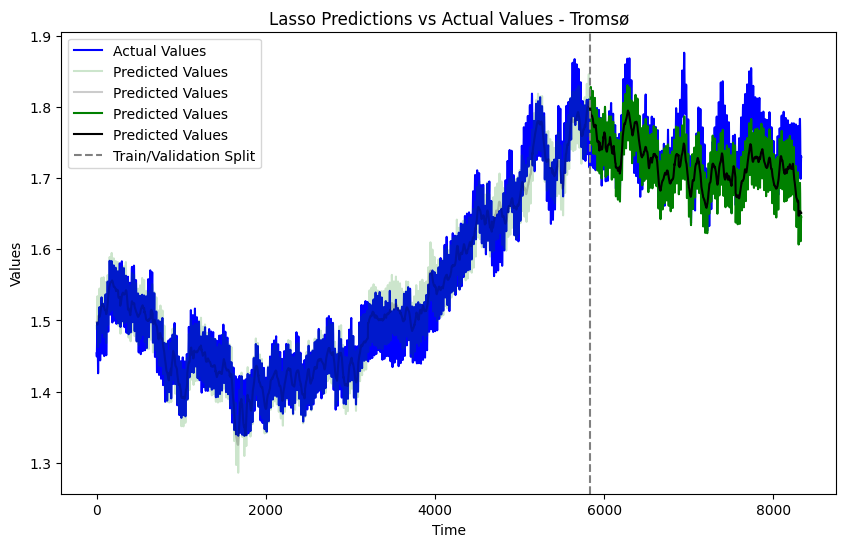

Out of sample MAPE: 1.705855995248784
Mean oveprediction: 0.8895114852468199
Mean underprediction: 1.8846553537809216
MAPE with trend prediction only: 2.0485578966184157
Intercept: 
1.5370410539748895
Coefficients: 
is_holiday: 0.010384293031823961
is_weekend: 0.002513405896125045
hour: 0.00010683701233518139
month: 0.04077944556259019
temperature_seasonal: 0.08164625375714638
spot_price_seasonal: 0.0044273481035781445
temperature_trend_L119: 0.0031645398148023632
temperature_trend_L120: 0.0023211374835516805
temperature_trend_L121: 0.001427690554069523
temperature_trend_L122: 0.0006814471098984582
temperature_trend_L123: 0.000234344951258039
temperature_trend_L124: 5.430605517077102e-05
temperature_trend_L137: 0.00026143641191963223
temperature_trend_L138: 0.001654382453634145
temperature_trend_L139: 0.0017580231891303028
temperature_trend_L140: 0.00176151616792432
temperature_trend_L141: 0.0016975943048459683
temperature_trend_L142: 0.0015549914576332314
temperature_trend_L143: 0.001

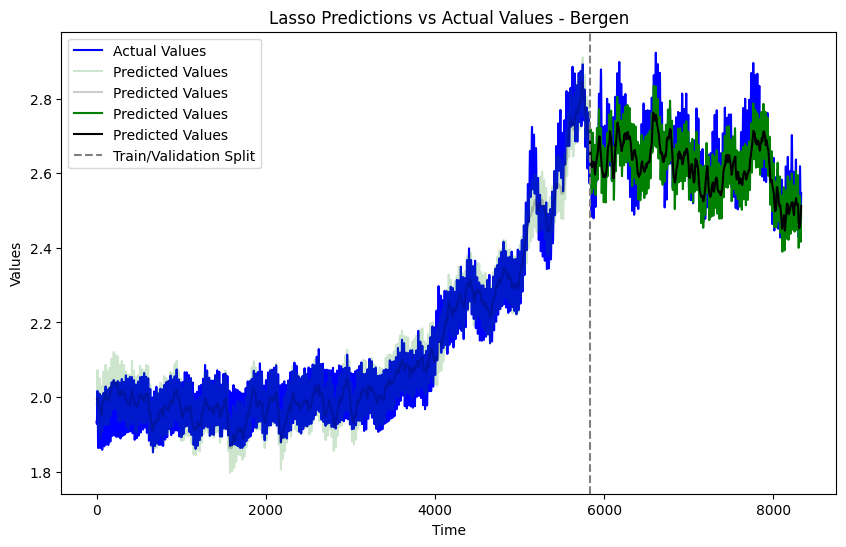

Out of sample MAPE: 2.0408183348718683
Mean oveprediction: 1.4051131917567001
Mean underprediction: 2.3092834550718995
MAPE with trend prediction only: 2.413254957839535
Intercept: 
1.9636010192338533
Coefficients: 
is_weekend: 0.011674187341107074
hour: 0.00029394264387443147
month: 0.04898712867514935
temperature_seasonal: 0.04569812912155181
spot_price_seasonal: 0.1424217427208466
temperature_trend_L118: 0.0008497215832961761
temperature_trend_L119: 0.006079896985328189
temperature_trend_L120: 0.004415666645390264
temperature_trend_L121: 0.0028383063838243244
temperature_trend_L122: 0.0014275787373240186
temperature_trend_L123: 0.0002881256364205205
temperature_trend_L143: 0.017909164995444017
temperature_trend_L144: 0.022306815797406315
temperature_seasonal_L24: 0.002110460462895984
temperature_seasonal_L25: 0.022565875841667683
temperature_seasonal_L26: 0.01867584992859594
temperature_seasonal_L27: 0.03464786003021885
temperature_seasonal_L28: 0.03617085924506296
temperature_seaso

In [ ]:
for I in range(5):
    data=DFS[I]
    print(DF_STRINGS[I])
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    #alpha1s = [2**(-24),2**(-22),2**(-20)]
    #alpha2s = [2.5*10**(-4), 5*10**(-4), 7.5*10**(-4)]

    alpha1s = [2**(-22)]
    alpha2s = [5*10**(-4)]
    # Grid Search
    best_mape = float('inf')
    best_hyperparams = None

    print("Alpha1, alpha2 --> MAPE")
    for alpha1 in alpha1s:
        for alpha2 in alpha2s:
            average_mape = cross_validate(data,alpha1,alpha2,mu,sig)
            print(f"{alpha1} {alpha2} --> {average_mape}")
            # Update best hyperparameters if current MAPE is lower
            if average_mape < best_mape:
                best_mape = average_mape
                best_hyperparams = (alpha1,alpha2)

    print(f'Best Hyperparameters: {best_hyperparams}')
    print(f'Best CV MAPE: {best_mape}%')

    model1 = Lasso(alpha=best_hyperparams[0])
    model2 = Lasso(alpha=best_hyperparams[1])
    X = data
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    thresh = np.floor(len(X) * (1 - VAL_SPLIT))
    X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
    y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
    y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

    model1.fit(X_train, y1_train)
    y1_pred = model1.predict(X_val)
    model2.fit(X_train, y2_train)
    y2_pred = model2.predict(X_val)

    X = DFS[I]
    y1 = X["consumption_seasonal"]
    y2 = X["consumption_trend"]
    X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

    train_pred1 = model1.predict(X_train)
    train_pred2 = model2.predict(X_train)

    actual = (y1 + y2)
    full_preds = np.concatenate(((train_pred1 + train_pred2).T,(y1_pred + y2_pred).T)).T
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    # Create an array of indices for plotting
    xs = range(len(actual))
    xs_train = range(len(train_pred1))
    xs_oos = range(len(train_pred1),len(train_pred1)+len(y1_pred))

    # Plot actual values and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(xs, actual * sig + mu, label='Actual Values', color='blue')
    plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='Predicted Values', color='green',alpha=0.2)
    plt.plot(xs_train, (train_pred2) * sig + mu, label='Predicted Values', color='black',alpha=0.2)
    plt.plot(xs_oos, (y1_pred + y2_pred) * sig + mu, label='Predicted Values', color='green')
    plt.plot(xs_oos, (y2_pred) * sig + mu, label='Predicted Values', color='black')
    plt.axvline(len(train_pred1), linestyle='--', color='gray', label='Train/Validation Split')
    plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)
    oos_MAPE = np.mean(np.abs(resids)) * 100
    error_95 = np.percentile(np.abs(resids),95)
    mape_positive = resids[resids < 0].mean()*-100
    mape_negative = resids[resids > 0].mean()*100
    mape_trend = np.mean(np.abs(((y1_val+y2_val)*sig - (y2_pred)*sig) / ((y1_val+y2_val)*sig+mu)))*100
    print(f"Out of sample MAPE: {oos_MAPE}")
    print(f"Mean oveprediction: {mape_positive}")
    print(f"Mean underprediction: {mape_negative}")
    print(f"MAPE with trend prediction only: {mape_trend}")

    coefs1 = model1.coef_
    coefs2 = model2.coef_
    cols = X.columns
    coefs_total= (coefs1+coefs2)*sig
    print("Intercept: ")
    print(model1.intercept_+model2.intercept_+mu)
    print("Coefficients: ")
    for i in range(len(cols)):
        if coefs_total[i]>0:
            print(f"{cols[i]}: {coefs_total[i]}")

    combined_list = list(zip(cols, coefs_total))

# Sorting by the absolute value of coefficients
sorted_list = sorted(combined_list, key=lambda x: abs(x[1]), reverse=True)
top_10 = sorted_list[:10]
top_cols, top_coefs = zip(*top_10)
plt.figure(figsize=(10, 6))
plt.bar(top_cols, top_coefs, color='green')
plt.title('Top 10 Important Features by Coefficient')
plt.xlabel('Columns')
plt.ylabel('Coefficients')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.show()
